### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

/home/ck2/miniconda3/envs/base38/lib/python3.8/site-packages/assimulo/solvers/odepack.py:710: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order


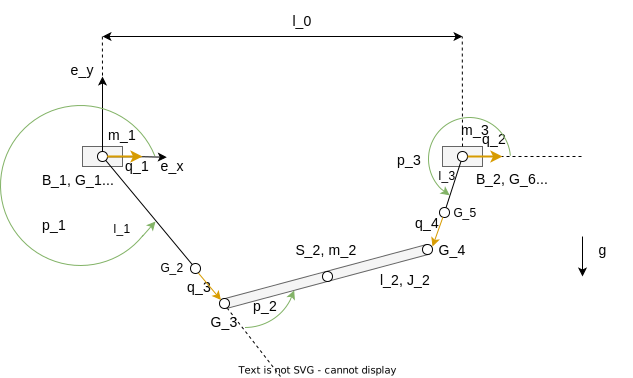

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
#TODO: p2 is absolute now
SVG(filename='DAE_double_crane_fully_actuated.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T

st.make_global(ttheta, tthetad, tthetadd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


In [5]:
eq = tau1 + tau2**2

In [6]:
sp.print_python([eq, eq+7])

tau1 = Symbol('tau1')
tau2 = Symbol('tau2')
e = [tau1 + tau2**2, tau1 + tau2**2 + 7]


Specify the geometry (joints G and centers of masses S)

---

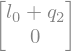

---

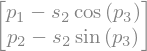

---

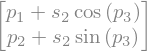

---

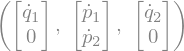

---

In [7]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])


# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:


# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

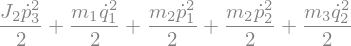

---

---

In [8]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0] + J2/2 * (pdot3)**2
T3 = (m3/2 * Sd3.T*Sd3)[0]

T = T1 + T2 + T3 ##:

# potential energy, for l1 <= l2
V = m2*g*S2[1] ##:

this model is very easy ...

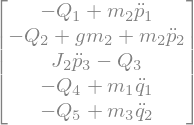

In [9]:

mod = mt.generate_symbolic_model(T, V, ttheta, QQ)
mod.eqns

... but $Q_i$ are yet unknown → calculate them via the principle of virtual work, see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Generalized_forces#Virtual_work):
$$
\delta W = \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_1} \delta q_1 +\ldots+ \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_m} \delta q_m.
$$

- $ \mathbf {F}_{i}$ applied forces, i.e.  $i=1,2$ → cart-forces, $i=3,4$ → rope-foces
- $ \mathbf {r}_{i}$ position vectors of each particle: $i=1,3$ → cart, $i=2$ → load
- $ \mathbf {\delta r}_{i}$ virtual displacement
- $ \mathbf \delta \theta_{j}$ virtual displacement of generalized coordinates


The virtual work of a system of particles can be written in the form

$$
    \delta W = Q_1\delta q_1 + \ldots + Q_m\delta q_m,
$$
where

$$
    Q_j = \sum_{i=1}^n \frac {\partial \mathbf {r}_i} {\partial q_j} \cdot \mathbf {F}_{i}  ,\quad j=1,\ldots, m, 
$$

---

---

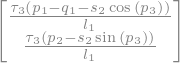

---

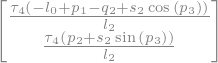

---

In [10]:
F1 = sp.Matrix([tau1, 0])  ##:T
F2 = sp.Matrix([tau2, 0])  ##:T

# unit vectors for ropes
rope1 = (G3 - S1)
rope2 = (G4 - S3)
uv_rope1 = rope1/sp.sqrt((rope1.T*rope1)[0])
uv_rope2 = rope2/sp.sqrt((rope2.T*rope2)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope1 = rope1/l1
uv_rope2 = rope2/l2

F3 = uv_rope1 * tau3 ##:
F4 = uv_rope2 * tau4 ##:

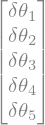

---

In [11]:
dt1, dt2, dt3, dt4, dt5 = ddelta_theta = st.symb_vector(f"\\delta\\theta_1:{n+1}") ##:

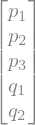

In [12]:
ttheta

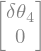

---

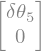

---

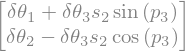

---

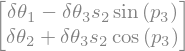

---

In [13]:
delta_S1 = S1*0
delta_S3 = S3*0

delta_G3 = G3*0 
delta_G4 = G4*0



for theta, delta_theta in zip(ttheta, ddelta_theta):
    
    delta_S1 += S1.diff(theta)*delta_theta
    delta_S3 += S3.diff(theta)*delta_theta
    
    delta_G3 += G3.diff(theta)*delta_theta
    delta_G4 += G4.diff(theta)*delta_theta
    
delta_S1 ##:
delta_S3 ##:

delta_G3 ##:
delta_G4 ##:

---

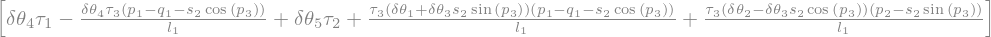

---

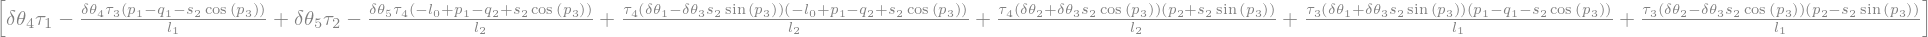

---

In [14]:
# simple part (carts)
delta_W = delta_S1.T*F1 + delta_S3.T*F2 ##:

# rope1 (F3 > 0 means rope is pushing from S1 towards G3)
delta_W = delta_W + delta_G3.T*F3 - delta_S1.T*F3 ##:

# rope2 (F4 > 0 means rope is pushing from S3 towards G4)
delta_W = delta_W + delta_G4.T*F4 - delta_S3.T*F4 ##:

# convert from 1x1 Matrix to scalar:
# delta_W = delta_W[0, 0] ##:

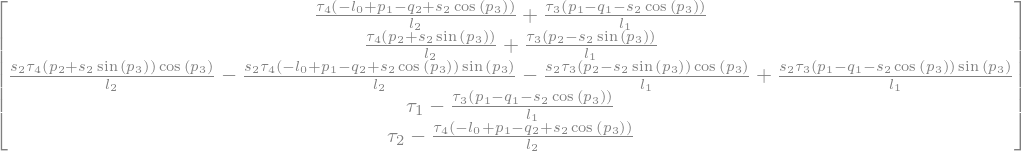

---

In [15]:
QQ_expr = delta_W.jacobian(ddelta_theta).T ##:

In [16]:
eqns = mod.eqns.subz(QQ, QQ_expr)

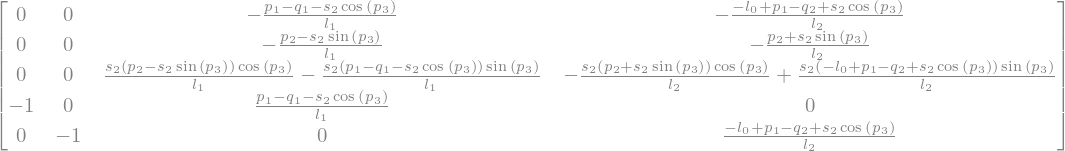

In [17]:
eqns.jacobian(ttau)

In [18]:
# eliminate the last two equations → 3 remaing

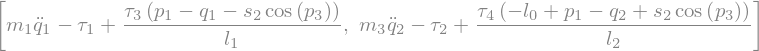

---

---

In [19]:
eliminated_equations = list(eqns[-2:, :]) ##:
eliminated_variables = list(ttau[:2]) ##:

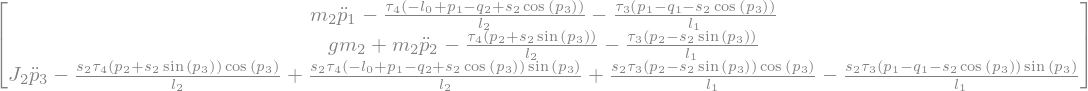

---

In [20]:
eqns1 = eqns[:-2, :] ##:

In [21]:
ttau1 = ttau[2:, :] ##:

---

now we have two inputs distributed over three equations. The $3\times 2$ coefficient matrix $B_1$ is the following:

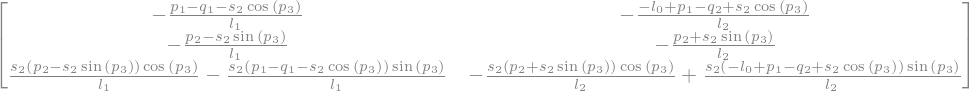

---

In [22]:
B1 = eqns1.jacobian(ttau1) ##:

We need its left pseudoinverse, i.e. the $2 \times 3$ matrix $B_1^{L+}$ with $B_1^{L+} B_1 = I_2$ and its left Orthocomplement $B_1^{L\perp}$ ($1 \times 3$) with $B_1^{L\perp} B_1 = 0_{1 \times 2}$

Note: both matrices are not unique: There are infinitely many Pseudoinverses and Othocomplements.

In [23]:
B1pinv = B1[:2, :].inverse_ADJ() # this is 2 x 2
B1pinv = st.col_stack(B1pinv, sp.Matrix([0, 0]))

B1pinv.shape


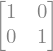

---

In [24]:
# check
tmp = (B1pinv * B1).smplf ##:


assert tmp == sp.eye(2)

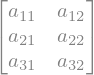

---

In [25]:
# nullspace (orthocomplement)

A = st.symbMatrix(3, 2)##:

In [26]:
A_ortho = st.nullspaceMatrix(A.T).T ##:

---

In [27]:
B1_ortho = A_ortho.subz(list(A), list(B1)).smplf*l1*l2 ##:

---

In [28]:
# check orthocomplement property:
res = (B1_ortho * B1).smplf ##:
assert not any(res)

---

Now we can assemble the $3\times 3$ transformation matrix:

$$
W_1 = 
\left(\begin{matrix}
B_1^{L+} \\
B_1^{L\perp}
\end{matrix} \right)
$$

In [29]:
W1 = st.row_stack(B1pinv, B1_ortho) ##:i

info(W1) := "<class 'sympy.matrices.dense.MutableDenseMatrix'> with count_ops: Matrix([[34, 35, 0], [33, 35, 0], [38, 33, 19]])"

---

In [30]:
eqns2 = (W1*eqns1).smplf

In [31]:
ttau1

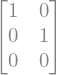

---

In [32]:
B2 = eqns2.jacobian(ttau1).smplf ##:
assert B2 == sp.eye(3)[:, :2]

In [33]:
# manually simplify the equations

eqns2a = eqns2.subz0(ttau1).smplf + B2 * ttau1

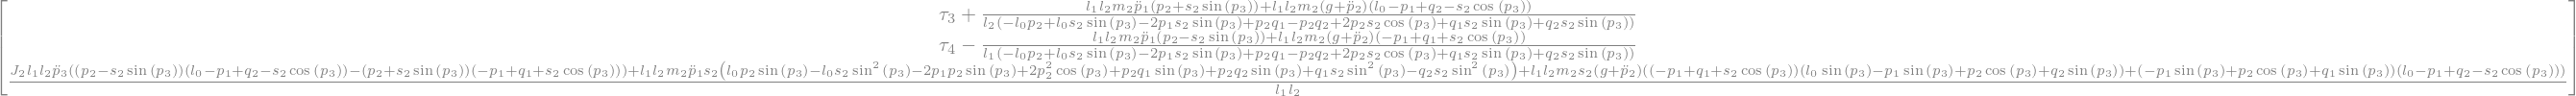

In [34]:
eqns2.subz0(ttau1) + B2*ttau1

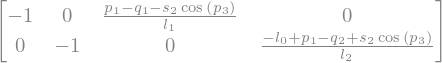

---

In [35]:
# eliminate the first two equations and tau3, tau4

if 0:
    eliminated_equations.extend(list(eqns2a[:2, :]))
    eliminated_variables.extend(list(ttau1))


sp.Matrix(eliminated_equations).jacobian(ttau) ##:

In [36]:
# this is the last equation:
eqn3 = (eqns2[-1, 0] *l1*l2).smplf

In [37]:
# examine contained symbols and assert that tau3 and tau4 are gone

eqn3.expand().s ##:

assert eqn3.expand().s.intersection(ttau1) == set()

---

In `eqn3` $q_1, q_2$ only occur algebraicly:  the structure is $0 = \kappa_0 + \kappa_{1, 0} q_1+ \kappa_{0,1} q_2 + \kappa_{1, 1} q_1 q_2$. Thus, $q_2$ (or $q_1$) can be eliminated, together with the last equation:

$$
0 = q_2 + \frac{\kappa_0 + \kappa_{1,0}q_1}{\kappa_{0,1} + \kappa_{1, 1}q_1}
$$

The remaining quantities form the flat output: $\mathbf{y} = (p_1, p_2, p_3, q_1)^T$.

All other quantities can be derived from $\mathbf y(\cdot)$: $q_2$ from `eqn3` and then the inputs from the earlier eliminated equations. Togehter the eliminated equations yield the parametrization of the system quantities by the flat output.

In [38]:
kappa_10 = eqn3.diff(q1).subs(q2, 0).smplf
kappa_01 = eqn3.diff(q2).subs(q1, 0).smplf
kappa_11 = eqn3.diff(q1).diff(q2).smplf


In [39]:
kappa_0 = (eqn3 - kappa_10*q1 - kappa_01*q2 - kappa_11*q1*q2).smplf

In [40]:
kk = sp.Matrix([kappa_0, kappa_01, kappa_10, kappa_11])


In [41]:
kk.s

In [42]:
eqn3a = q2 + ((kappa_0 + kappa_10*q1)/ (kappa_01 + kappa_11*q1))

In [43]:
eqn3a.co

In [44]:
eliminated_equations.append(eqn3a)
eliminated_variables.append(q2)

In [45]:
for i, e in enumerate(eliminated_equations):
    print(i, e.s)

0 {tau1, p3, q1, m1, qddot1, l1, p1, s2, tau3}
1 {m3, tau2, p3, qddot2, l2, l0, p1, tau4, s2, q2}
2 {g, pddot2, p3, pddot1, J2, q1, p2, l2, pddot3, l1, p1, l0, s2, m2, q2}


In [46]:
eqn3a.s

In [47]:
eqn3a_dd = st.time_deriv(eqn3a, ttheta)

In [48]:
eqn3a_dd.co

We can express the input in terms of the flat output and its derivatives: $\boldsymbol{\tau} = \mathbf A(\mathbf y, \ldots, \mathbf y^{(4)})$ were only $\tau_2$ depends on order 4, the rest depends on order 2.

New input: $\mathbf v := \mathbf y^{(4)}$

Feedback law (with yet unspecified new input):
$\boldsymbol{\tau} = \mathbf A(\mathbf y, \ldots, \mathbf y^{(3)}, \mathbf v)$

Tracking-Error: $\mathbf e := \mathbf y_d - \mathbf y$

Stable Tracking-Error ODE: $\mathbf 0 = \mathbf e^{(4)} + \mathbf K_3 \mathbf e^{(3)} + \ldots +  \mathbf K_0 \mathbf e$. $\qquad$ (Note that $\mathbf e^{(4)}$ contains $\mathbf y^{(4)} = \mathbf v$.)

Stabilizing Feedback:
$$
\boldsymbol{\tau} = \mathbf A(\mathbf y, \ldots, \mathbf y^{(3)}, \mathbf v)
\qquad \text{with}
\quad
\mathbf v = \mathbf y_d^{(4)} + \mathbf K_3 \mathbf e^{(3)} + \ldots +  \mathbf K_0 \mathbf e
$$

Challenge: This requires to know $\mathbf y^{(3)}$ at runtime (i.e. the real $\mathbf y^{(3)}$, not the planned one).


Solution: Statespace representation

\begin{align*}
\dot {\mathbf x} &= \mathbf f (\mathbf x) + \mathbf g(\mathbf x) \boldsymbol \tau \\
\mathbf y &= \mathbf h (\mathbf x)
\end{align*}

Ausgangsableitungen lassen sich über die Zustandsdarstellung bestimmen. Dabei treten dann wieder Ableitungen vom Eingang u auf

---

anders: die Ableitungen von y können durch Komponenten des Reglerzustands $\boldsymbol \xi$ ausgedrückt werden.



# Simulation model

In [49]:
# resubstitute the rope lengths:
mod.eqns = eqns.subz([l1, l2], [sp.sqrt((rope1.T*rope1)[0]), sp.sqrt((rope2.T*rope2)[0])])

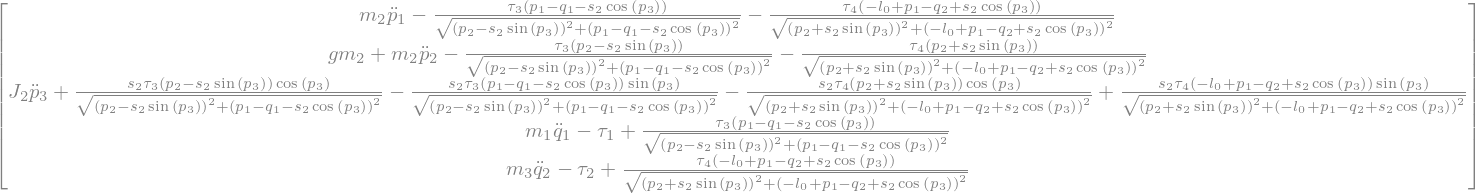

In [50]:
mod.eqns

In [51]:
mod.tau = ttau

In [52]:
mod.calc_state_eq(force_recalculation=True)

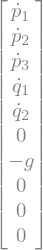

In [53]:
mod.f

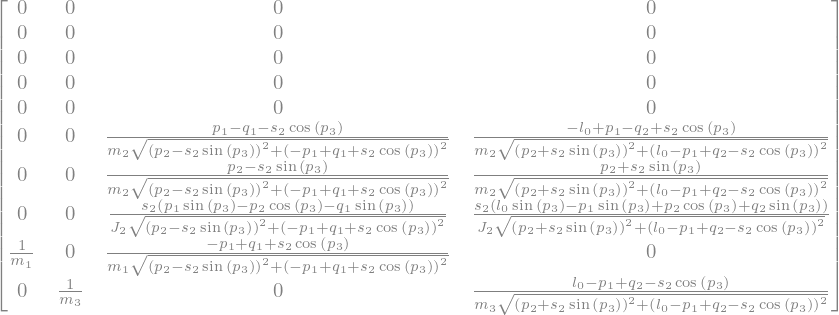

In [54]:
mod.g

In [55]:
used_params = []
for s in mod.eqns.s:
    if s not in [*ttheta, *tthetad, *tthetadd, *ttau]:
        used_params.append(s)

used_params.sort(key=str)
used_params ##:

---

In [56]:
num_params = [0.1, 9.81, 2, 10, 10, 10, 1]

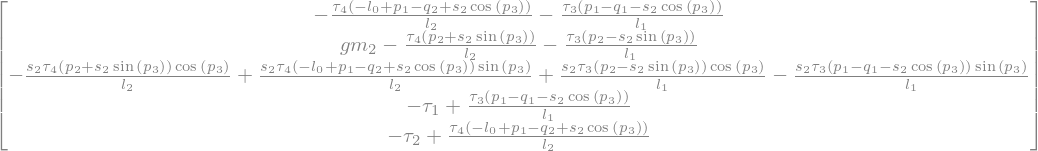

In [57]:
eqns.subz0(tthetadd)

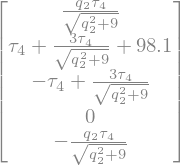

---

In [58]:
# determine a symetrical equilibrium:

eqlbr_conditions = [(q1, 0), (p3, 0), (p1, 1), (p2, -3), (tau1, 0), (tau2, 0), (tau3, tau4)]

res = mod.eqns.subz0(tthetadd).subs(eqlbr_conditions).subz(used_params, num_params) ##:

In [60]:
symbs = list(res.s) ##:
sol = sp.solve(res, symbs, dict=True)[0] ##:

---

---

In [61]:
ttheta0 = st.to_np(ttheta.subs(eqlbr_conditions).subs(sol)).squeeze() ##:

uu0 = st.to_np(ttau.subs(eqlbr_conditions).subs(sol)).squeeze()##:

ttheta0 := array([ 1., -3.,  0.,  0.,  0.])

---

uu0 := array([  0.  ,   0.  , -49.05, -49.05])

---

In [62]:
sim = st.SimulationModel(mod.f, mod.g, mod.xx, model_parameters=list(zip(used_params, num_params)))

In [63]:
# return a constant value for simplicity
uu1 = npy.array([  1.  ,   0.  , -49.05, -49.05])

def input_func(t):
    # constant input
    return uu1

rhs = sim.create_simfunction(input_function=input_func)

In [64]:
import numpy as npy
import scipy as sc
import scipy.integrate

In [65]:
xx0 = npy.concatenate((ttheta0, ttheta0*0)) ##:

xx0 := array([ 1., -3.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.])

---

In [ ]:
tt = npy.linspace(0, 10, 1000)

In [ ]:
# solve_ivp is more modern, but the signature of rhs is taylored towards odeint
res = sc.integrate.odeint(rhs, xx0, tt) ##:i

In [ ]:
plt.plot(tt, res[:, :5])